In [1]:
import pandas
import os
import numpy as np
import torch
import gates_models as gm
import pickle
import utils as ut
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LogisticRegression
import numpy as np
import torch
import os
import torch.nn as nn
import numpy as np
import pickle
from torch.optim import Adam, SGD
import utils as ut
import model_factories as m
from collections.abc import Iterable
from sklearn.cluster import KMeans

In [2]:
round_suffix = 'r5'
subset = 'all'
path = f'models_{round_suffix}'
main_path = os.path.join(path, 'round6-train-dataset') if round_suffix == 'r6' else os.path.join(path, 'round5-train-dataset')
models_path = os.path.join(main_path, 'models')
metadata_file = 'METADATA.csv'    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
df = pandas.read_csv(os.path.join(main_path, metadata_file))
df = df[0:11]##delete it in normal case
torch.backends.cudnn.enabled=False
use_amp = False

In [3]:
with open(os.path.join(f'data_{round_suffix}', 'embeddings.pickle'), 'rb') as handle:
    data =  pickle.load(handle)

In [4]:
data['embeddings']#we are using only the first embedding so there are 40 samples for each model
data["logits"]#models prediction for 40 samples
data['instance_labels']#labels of 40 samples for each model
data['model_labels']#shows whether the model is poisoned or not.
print("data is okey")

data is okey


In [5]:
all_embeddings, all_labels = data['embeddings'], data['instance_labels']

In [6]:
idx = 0
params = ut.read_model(df, idx, main_path, models_path)
model_poison = torch.load(params[3], map_location=device)
print(f'Idx: {idx} - Poisoned: {params[2]} - Embedding: {os.path.basename(params[6])} - Arch: {params[1]} ')

Idx: 0 - Poisoned: True - Embedding: GPT-2-gpt2.pt - Arch: GruLinear 


In [7]:
idx = 3
params = ut.read_model(df, idx, main_path, models_path)
model_clean = torch.load(params[3], map_location=device)
print(f'Idx: {idx} - Poisoned: {params[2]} - Embedding: {os.path.basename(params[6])} - Arch: {params[1]} ')

Idx: 3 - Poisoned: False - Embedding: GPT-2-gpt2.pt - Arch: GruLinear 


In [8]:
def get_acc(preds, targets):
    classes = np.argmax(preds, axis=1)
    tot_correct = np.sum(classes == targets)
    acc = tot_correct/len(classes)
    return acc

In [9]:
def distort(x, factor):  # pylint: disable=arguments-differ
    return x.mul(factor).add(.5).floor().div(factor)

In [10]:
embeddings = all_embeddings[0]
targets = all_labels[0]
embeddings_ = np.expand_dims(embeddings, axis=1) # sequence length 1 (seq,1,batch,embed)?
embeddings_ = torch.from_numpy(embeddings_).to(device)
logits = model_poison(embeddings_)
preds = nn.functional.softmax(logits, dim=1) #only making a prediction.
get_acc(preds.detach().numpy(), targets)

1.0

In [11]:
embeddings = all_embeddings[3]
targets = all_labels[3]
embeddings_ = np.expand_dims(embeddings, axis=1) # sequence length 1 (seq,1,batch,embed)?
embeddings_ = torch.from_numpy(embeddings_).to(device)
logits = model_clean(embeddings_)
preds = nn.functional.softmax(logits, dim=1) #only making a prediction.
get_acc(preds.detach().numpy(), targets)

1.0

(array([ 5.,  3.,  0.,  1.,  2.,  1.,  8.,  4., 10., 11., 13., 22., 19.,
        28., 37., 39., 46., 51., 43., 66., 68., 60., 69., 60., 62., 49.,
        52., 48., 30., 33., 19., 16., 12.,  5.,  9.,  5.,  7.,  2.,  2.,
         1.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.]),
 array([-0.10291766, -0.09808733, -0.09325699, -0.08842665, -0.08359631,
        -0.07876597, -0.07393564, -0.0691053 , -0.06427497, -0.05944463,
        -0.05461429, -0.04978395, -0.04495361, -0.04012328, -0.03529294,
        -0.0304626 , -0.02563227, -0.02080193, -0.01597159, -0.01114125,
        -0.00631092, -0.00148058,  0.00334976,  0.00818009,  0.01301043,
         0.01784077,  0.02267111,  0.02750144,  0.03233178,  0.03716212,
         0.04199246,  0.04682279,  0.05165313,  0.05648347,  0.0613138 ,
         0.06614414,  0.07097448,  0.07580481,  0.08063515,  0.08546549,
         0.09029583,  0.09512617,  0.09995651,  0.10478684,  0.10961718,
         0.11444752,  0.11927785,  0.12410819,  0.12893853,

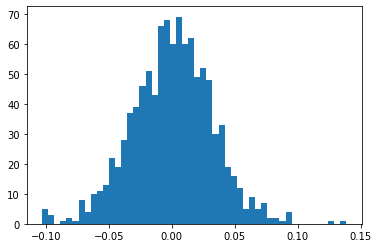

In [12]:
plt.hist(model_clean.linear.weight.flatten().detach().numpy(),bins=50)

In [13]:
acc_clean = []
loss_clean= []
distort_factor = range(256)
for dist in distort_factor:
    idx = 3
    params = ut.read_model(df, idx, main_path, models_path)
    model_clean = torch.load(params[3], map_location=device)
    d = model_clean.state_dict()
    with torch.no_grad():
        d = model_clean.state_dict()
        for key in d:
            d[key][:] = distort(d[key],dist)    
    embeddings = all_embeddings[idx]
    targets = all_labels[idx]
    embeddings_ = np.expand_dims(embeddings, axis=1)
    embeddings_ = torch.from_numpy(embeddings_).to(device)
    logits = model_clean(embeddings_)
    loss = nn.CrossEntropyLoss()
    loss_r = loss(logits,torch.tensor(targets)).detach().numpy()
    preds = nn.functional.softmax(logits, dim=1) #only making a prediction.
    acc = get_acc(preds.detach().numpy(), targets)
    acc_clean.append(acc)
    loss_clean.append(loss_r)

In [14]:
acc_poison = []
loss_poison = []
distort_factor = range(256)
for dist in distort_factor:
    idx = 0
    params = ut.read_model(df, idx, main_path, models_path)
    model_poison = torch.load(params[3], map_location=device)
    d = model_poison.state_dict()
    with torch.no_grad():
        d = model_poison.state_dict()
        for key in d:
            d[key][:] = distort(d[key],dist)    
    embeddings = all_embeddings[idx]
    targets = all_labels[idx]
    embeddings_ = np.expand_dims(embeddings, axis=1)
    embeddings_ = torch.from_numpy(embeddings_).to(device)
    logits = model_poison(embeddings_)
    loss = nn.CrossEntropyLoss()
    loss_r = loss(logits,torch.tensor(targets)).detach().numpy()
    preds = nn.functional.softmax(logits, dim=1) #only making a prediction.
    acc = get_acc(preds.detach().numpy(), targets)
    acc_poison.append(acc)
    loss_poison.append(loss_r)

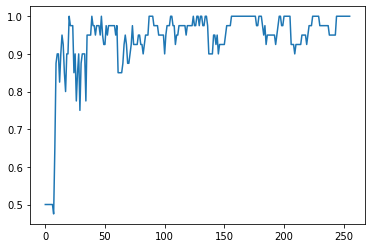

In [15]:
plt.plot(range(len(acc_clean)),acc_clean )

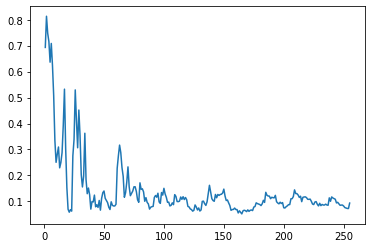

In [16]:
plt.plot(range(len(loss_clean)),loss_clean )

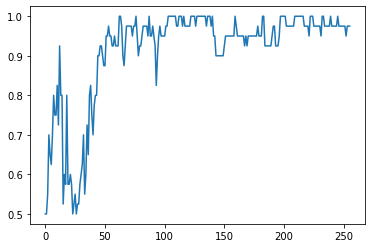

In [17]:
plt.plot(range(len(acc_poison)),acc_poison)

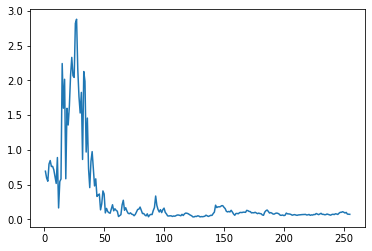

In [18]:
plt.plot(range(len(loss_poison)),loss_poison)

In [19]:
acc_clean = []
loss_clean= []
distort_factor = range(256)
for dist in distort_factor:
    idx = 7
    params = ut.read_model(df, idx, main_path, models_path)
    model_clean = torch.load(params[3], map_location=device)
    d = model_clean.state_dict()
    with torch.no_grad():
        d = model_clean.state_dict()
        for key in d:
            d[key][:] = distort(d[key],dist)    
    embeddings = all_embeddings[idx]
    targets = all_labels[idx]
    embeddings_ = np.expand_dims(embeddings, axis=1)
    embeddings_ = torch.from_numpy(embeddings_).to(device)
    logits = model_clean(embeddings_)
    loss = nn.CrossEntropyLoss()
    loss_r = loss(logits,torch.tensor(targets)).detach().numpy()
    preds = nn.functional.softmax(logits, dim=1) #only making a prediction.
    acc = get_acc(preds.detach().numpy(), targets)
    acc_clean.append(acc)
    loss_clean.append(loss_r)

In [25]:
acc_poison = []
loss_poison = []
distort_factor = range(256)
for dist in distort_factor:
    idx = 4
    params = ut.read_model(df, idx, main_path, models_path)
    model_poison = torch.load(params[3], map_location=device)
    d = model_poison.state_dict()
    with torch.no_grad():
        d = model_poison.state_dict()
        for key in d:
            d[key][:] = distort(d[key],dist)    
    embeddings = all_embeddings[idx]
    targets = all_labels[idx]
    embeddings_ = np.expand_dims(embeddings, axis=1)
    embeddings_ = torch.from_numpy(embeddings_).to(device)
    logits = model_poison(embeddings_)
    loss = nn.CrossEntropyLoss()
    loss_r = loss(logits,torch.tensor(targets)).detach().numpy()
    preds = nn.functional.softmax(logits, dim=1) #only making a prediction.
    acc = get_acc(preds.detach().numpy(), targets)
    acc_poison.append(acc)
    loss_poison.append(loss_r)

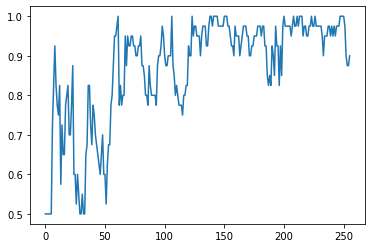

In [28]:
plt.plot(range(len(acc_clean)),acc_clean )

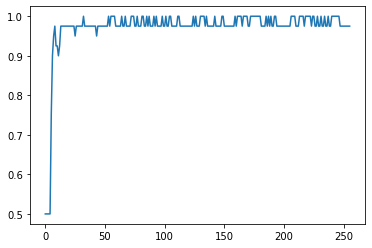

In [27]:
plt.plot(range(len(acc_poison)),acc_poison )

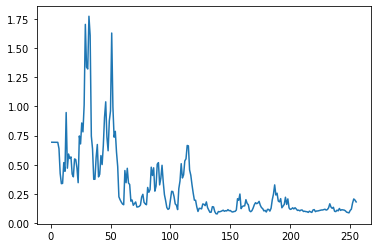

In [29]:
plt.plot(range(len(loss_clean)),loss_clean )

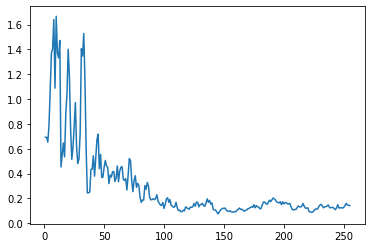

In [24]:
plt.plot(range(len(loss_poison)),loss_poison)

In [ ]:
count = 0
d = model_clean.state_dict()
with torch.no_grad():
    d = model_clean.state_dict()
    for key in d:
        count += 1
        print(count)
        if len(d[key].flatten()) > 1024:
            shape = d[key].shape
            new = KMeans(n_clusters=1024, random_state=0).fit_transform(d[key].flatten().reshape(-1,1))
            d[key][:] = torch.tensor(np.min(new,1).reshape(shape))
        
        

In [ ]:
embeddings = all_embeddings[0]
targets = all_labels[0]
embeddings_ = np.expand_dims(embeddings, axis=1)
embeddings_ = torch.from_numpy(embeddings_).to(device)
logits = model_clean(embeddings_)
preds = nn.functional.softmax(logits, dim=1) #only making a prediction.
get_acc(preds.detach().numpy(), targets)

In [ ]:
new = KMeans(n_clusters=10, random_state=0).fit_transform(model_clean.state_dict()['rnn.weight_ih_l0'].flatten().reshape(-1,1))

In [ ]:
kmeans.predict(model_clean.state_dict()['rnn.weight_ih_l0'].flatten().reshape(-1,1))

In [ ]:
np.min(new,1).shape

In [ ]:
kmeans = KMeans(n_clusters=10, random_state=0).fit(model_clean.state_dict()['rnn.weight_ih_l0'].flatten().reshape(-1,1))

In [ ]:
np.sum(kmeans.labels_  == np.argmin(new,1))

In [ ]:
len(model_clean.state_dict()['rnn.weight_ih_l0'])